# KNMI daggegevens

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm

### Get the data

In [94]:
!ls ../datasets/knmi

etmgeg_260.txt etmgeg_279.txt result.txt


In [95]:
filename = '../datasets/KNMI/result.txt'
nrows_header = 9
df = pd.read_csv(filename, skiprows=nrows_header, skipinitialspace=True)

In [96]:
df.rename(columns = lambda s: s.strip('# '), inplace = True)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   STN       732 non-null    int64
 1   YYYYMMDD  732 non-null    int64
 2   TG        732 non-null    int64
dtypes: int64(3)
memory usage: 17.3 KB


## Datums converteren

In [98]:
df['dd'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d')

In [99]:
dd0 = df['dd'].min()
dd1 = df['dd'].max()

print(dd0, dd1)

2024-01-01 00:00:00 2024-12-31 00:00:00


## Temperatuur waarden bijwerken

In [100]:
df['temp'] = df['TG'].astype('int') / 10

In [104]:
print('Laagste temperatuur:', df['temp'].min())
print('Hoogste temperatuur:', df['temp'].max())

Laagste temperatuur: -4.0
Hoogste temperatuur: 25.1


## Stations bijwerken

In [107]:
stations = {
    260: 'De Bilt',
    279: 'Hoogeveen'
}

df['station'] = df['STN'].astype('int').replace(stations)
station_names = list(stations.values())

In [109]:
df['station'].value_counts()

station
De Bilt      366
Hoogeveen    366
Name: count, dtype: int64

## Drop original columns

In [111]:
df.drop(['STN','YYYYMMDD','TG'], axis = 1, inplace = True)

KeyError: "['STN', 'YYYYMMDD', 'TG'] not found in axis"

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dd       732 non-null    datetime64[ns]
 1   temp     732 non-null    float64       
 2   station  732 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 17.3+ KB


In [116]:
df

,dd,temp,station
0,2024-01-01,7.4,De Bilt
1,2024-01-02,10.5,De Bilt
2,2024-01-03,9.4,De Bilt
3,2024-01-04,7.6,De Bilt
4,2024-01-05,7.0,De Bilt
...,...,...,...
727,2024-12-27,2.1,Hoogeveen
728,2024-12-28,-0.9,Hoogeveen
729,2024-12-29,3.2,Hoogeveen
730,2024-12-30,6.5,Hoogeveen


## Pivot

In [117]:
df_pivot = pd.pivot(df, index='dd', columns='station', values='temp')
df_pivot

station,De Bilt,Hoogeveen
dd,,
2024-01-01,7.4,6.9
2024-01-02,10.5,9.3
2024-01-03,9.4,8.8
2024-01-04,7.6,4.6
2024-01-05,7.0,4.8
...,...,...
2024-12-27,2.5,2.1
2024-12-28,1.0,-0.9
2024-12-29,4.0,3.2


## Plot

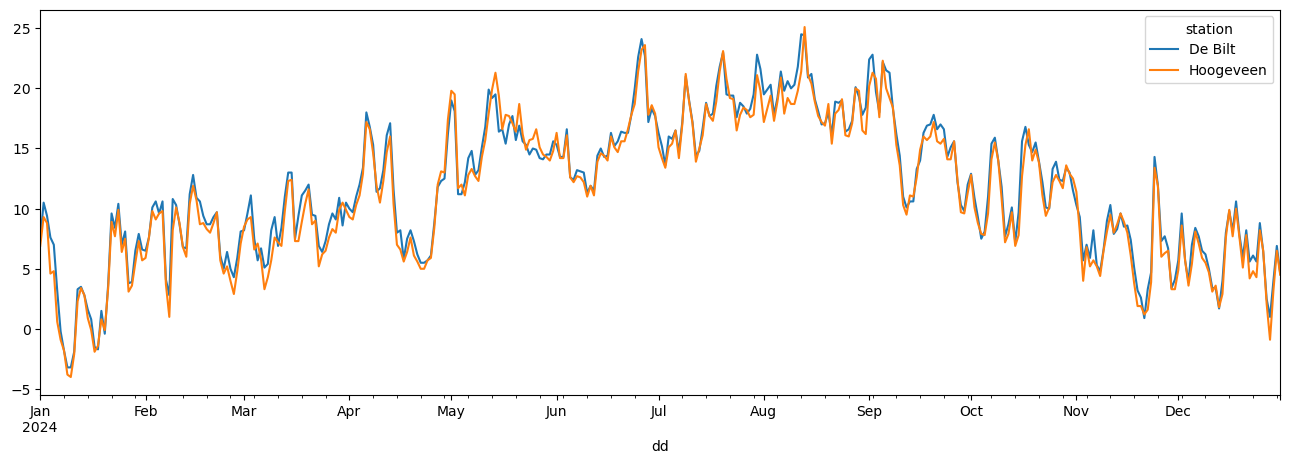

In [118]:
df_pivot.plot(kind = 'line', figsize = (16, 5));

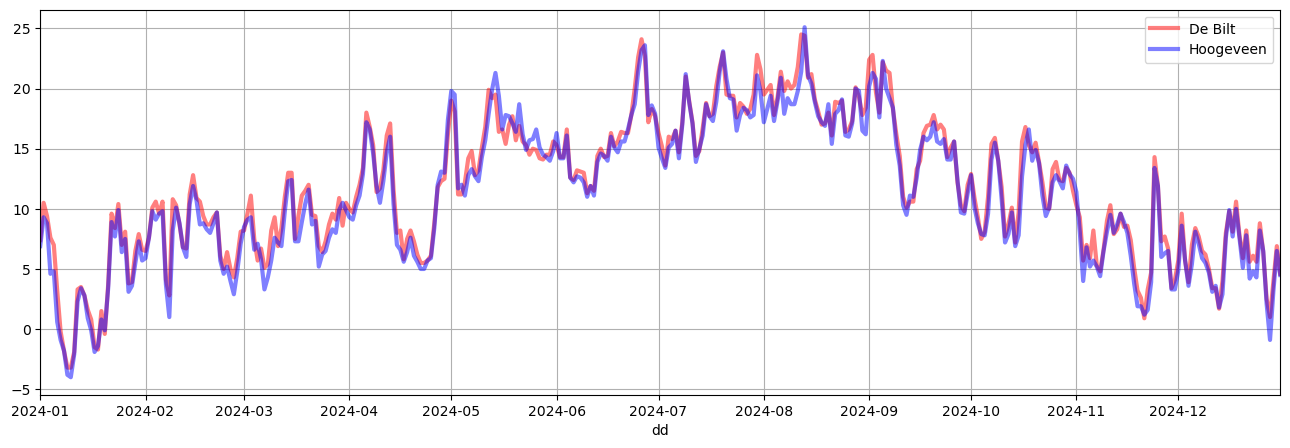

In [120]:
fig, ax = plt.subplots(figsize = (16, 5))

column_name = station_names[0]
ax.plot(df_pivot.index, 
        df_pivot[column_name], 
        color='red', 
        alpha = 0.5, 
        linewidth = 3, 
        linestyle = 'solid', 
        label = column_name)

column_name = station_names[1]
ax.plot(df_pivot.index, 
        df_pivot[column_name], 
        color='blue', 
        alpha = 0.5, 
        linewidth = 3, 
        linestyle = 'solid', 
        label = column_name)

ax.set_xlim(np.min(df_pivot.index), np.max(df_pivot.index))

ax.set_xlabel('dd')

plt.legend()
plt.grid()

plt.show()

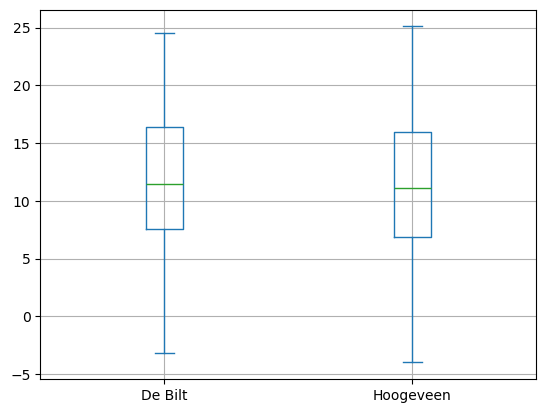

In [122]:
df_pivot.plot(kind='box')

plt.grid()
plt.show()

In [123]:
df_pivot.describe()

station,De Bilt,Hoogeveen
count,366.000000,366.000000
mean,11.798361,11.268306
std,5.700954,5.814430
min,-3.200000,-4.000000
25%,7.525000,6.900000
50%,11.500000,11.100000
75%,16.375000,16.000000
max,24.500000,25.100000


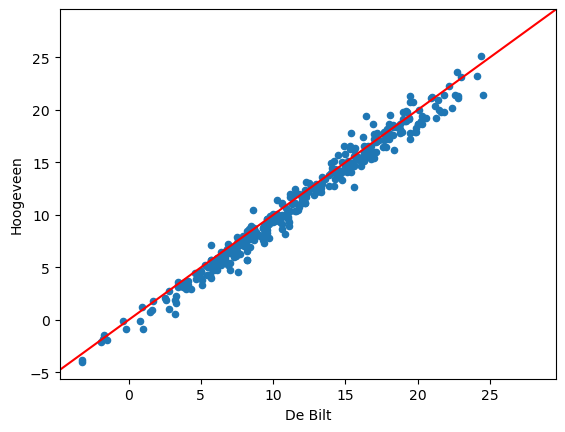

In [125]:
df_pivot.plot(kind = 'scatter', 
              x = station_names[0], 
              y = station_names[1])
plt.axline([0,0], [28,28], color = 'red')
plt.show()

In [ ]:
n_days = (dd1 - dd0).days + 1
dd0_formatted = dd0.strftime('%d-%m-%Y')
dd1_formatted = dd1.strftime('%d-%m-%Y')

n_days_colder = np.sum(df_pivot[station_names[1]] < df_pivot[station_names[0]])

print(f'''\
In de {n_days} dagen van {dd0_formatted} tot {dd1_formatted}
was het {n_days_colder} dagen kouder {station_names[1]} dan in {station_names[0]}.''')

In de 366 dagen van 01-01-2024 tot 31-12-2024
was het 280 dagen kouder Hoogeveen dan in De Bilt


## Temperatuurverschil

In [132]:
diff = df_pivot[station_names[1]] - df_pivot[station_names[0]]

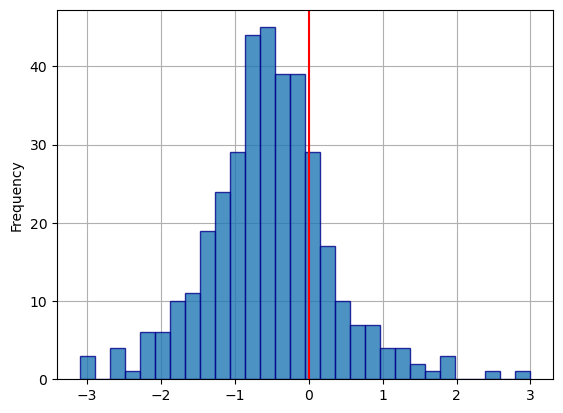

In [143]:
diff.plot(kind = 'hist', bins = 30, zorder=2, alpha=0.8, edgecolor='darkblue')
plt.axvline(0, color = 'red')
plt.grid()
plt.show()

In [144]:
diff.describe()

count    366.000000
mean      -0.530055
std        0.832704
min       -3.100000
25%       -1.000000
50%       -0.600000
75%       -0.100000
max        3.000000
dtype: float64

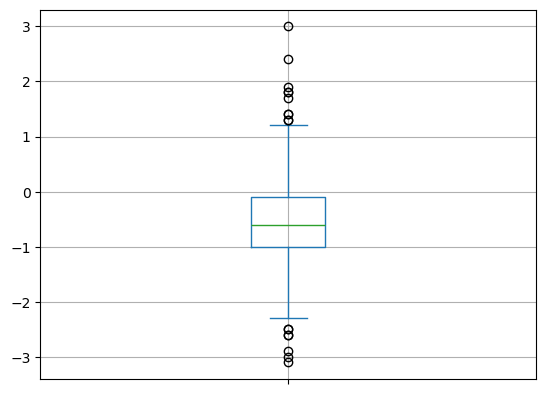

In [145]:
diff.plot.box()
plt.grid()
plt.show()

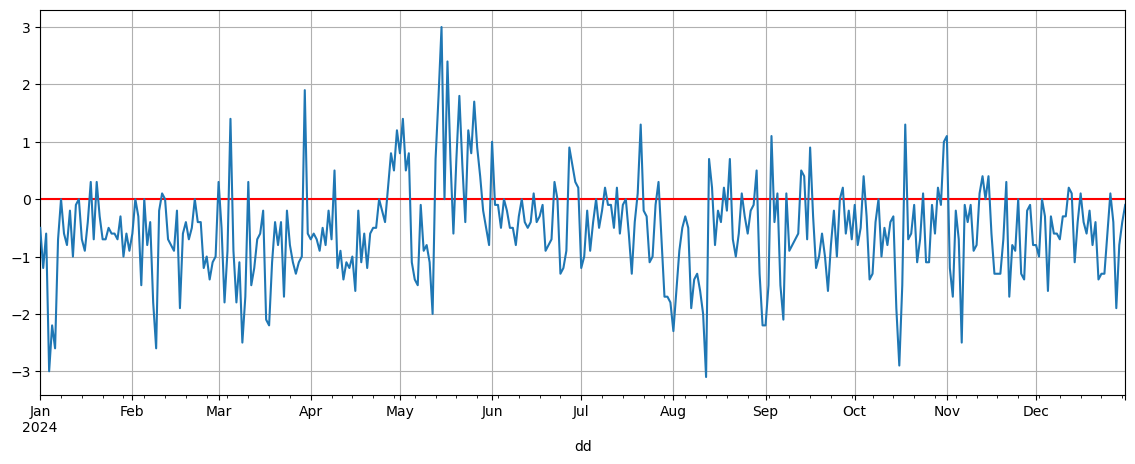

In [149]:
diff.plot(kind = 'line', figsize = (14, 5), zorder=3)
plt.axhline(0, color = 'red')
plt.grid()
plt.show()

## Normal distribution? Q-Q plot

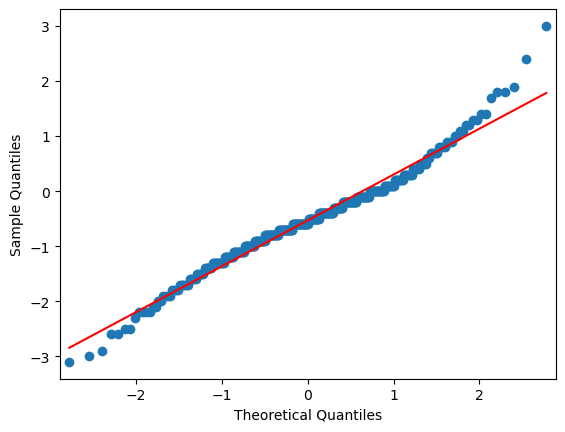

In [150]:
from statsmodels.graphics.api import qqplot

qqplot(diff, line='r')

plt.show()

## Student t-test

In [151]:
from scipy import stats

t, p = stats.ttest_1samp(diff, 0)

print("The t-statistic is %.3f and the p-value is %.5f." % (t, p/2))

The t-statistic is -12.178 and the p-value is 0.00000.
